# 📖 Agent 實作範例：自動化有聲書生成

本 Notebook 展示如何透過 Agent 串接 **故事 → 圖像 → 語音** 的自動化流程。  
每個步驟都會將輸出保存為檔案，避免重複 Token 消耗，並方便後續流程使用。

---

## 🔹 整體流程
1. 故事內容生成  
2. 圖片內容生成  
3. 語音內容生成  

---

## 1️⃣ 故事內容生成
**輸入**  
- 草稿文字  
- 既有內容 (`.txt` 檔案)  

**處理流程**  
1. 將文字送入 Langserve 服務  
2. 接收生成的故事段落  

**輸出**  
- 將結果存為 `.txt` 檔  
- 避免 Agent 一直傳遞整份故事，降低 Token 消耗  

---

## 2️⃣ 圖片內容生成
**輸入**  
- 最新生成的故事文字  
- 既有圖片 (`.png`)  

**處理流程**  
1. 將圖片編碼為 base64  
2. 文字與圖片送入 Langserve 服務  
3. 接收回傳的圖片（base64 格式）  

**輸出**  
- 將 base64 解碼為二進位資料，存成 `.png` 檔  

---

## 3️⃣ 語音內容生成
**輸入**  
- 最新生成的故事文字  

**處理流程**  
1. 將文字送入 Langserve 服務  
2. 接收回傳的語音（base64 格式）  

**輸出**  
- 將 base64 解碼為二進位資料，存成 `.mp3` 或 `.wav` 檔  

---

## 🔄 流程圖

```mermaid
flowchart TD
    A[故事草稿/舊內容 .txt] --> B[送入 Langserve 生成故事]
    B --> C[故事內容 .txt]
    C --> D[送入 Langserve 生成圖片 (base64)]
    D --> E[解碼並存為 .png]
    C --> F[送入 Langserve 生成語音 (base64)]
    F --> G[解碼並存為 .mp3 / .wav]


## LangServe 服務測試

In [ ]:
import os
import requests

os.chdir("../../../")

測試故事生成服務

In [ ]:
response = requests.post(
    "http://localhost:8080/story_telling/invoke",
    json={"input":{'scratch': "Create a chapter of a baby owl capturing a rodent in the night as his dinner",
                   'context': ""}
         }
)

In [ ]:
story_json = response.json()

In [ ]:
story_json['output']

測試影像生成服務

In [ ]:
import importlib

image_generation_module = importlib.import_module("tutorial.LLM+Langchain.Week-8.logic.image_generation")
image_create_pipeline = image_generation_module.image_create_pipeline(image_generation_module.system_template)

In [ ]:
response_image = requests.post(
    "http://localhost:8080/image_generation/invoke",
    json={"input": {'story': story_json['output'],
                    "image_io": []}
    }
)

In [ ]:
response_image.json()['output']['nl_prompt']

In [ ]:
import base64
# Decode to bytes
image_bytes = base64.b64decode(response_image.json()['output']['image_base64'])

with open("tutorial/LLM+Langchain/Week-8/story_2_image.png", "wb") as fh:
    fh.write(image_bytes)

測試生成後續後續的故事

In [ ]:
response_next_tory = requests.post(
    "http://localhost:8080/story_telling/invoke",
    json={"input":{'scratch': "Create the next chapter following the context",
                   'context': story_json['output']}
         }
)

In [ ]:
next_chapter = response_next_tory.json()['output']

根據故事和上一張圖片，產生出下一張圖片

透過requests送出base64 string.

本來是想要透過img2img的手法控制圖片風格和內容一致性的，但是發現不確定性很高，所以決定從上一張圖片的prompt下手，看看能不能調高一致性。

In [ ]:
response = requests.post(
    "http://localhost:8080/image_generation/invoke",
    json={"input": {'story': next_chapter + f"\nPrevious image description:\n\n{response_image.json()['output']['nl_prompt']}",
                    # 'image_io': [response_image.json()['output']['image_base64']]
                    'image_io': []
                   }
    }
)

In [ ]:
response.json()['output']['nl_prompt']

In [ ]:
import base64

image_bytes = base64.b64decode(response.json()['output']['image_base64'])

with open("tutorial/LLM+Langchain/Week-8/story_3_image.png", "wb") as fh:
    fh.write(image_bytes)

測試語音生成

In [ ]:
response = requests.post(
    "http://localhost:8080/audio_generation/invoke",
    json={"input": {'input': "How are you doing?"}}
)

In [ ]:
audio_bytes = base64.b64decode(response.json()['output'])

with open("tutorial/LLM+Langchain/Week-8/test_sample.mp3", "wb") as f:
    f.write(audio_bytes)


## 生成工具模板

In [ ]:
from textwrap import dedent
from typing import Optional, Any, List, Tuple, Callable
from pathlib import Path

from langchain_openai import ChatOpenAI
from langchain.output_parsers import PydanticOutputParser
from langchain.tools import BaseTool
from langchain_core.runnables import Runnable
from pydantic import BaseModel, Field
from pydantic import FilePath

from src.initialization import credential_init


class ToolTemplate(BaseTool):

    """
    ToolTemplateHTTP: 一個專門用來呼叫 Langserve REST API 的 Agent Tool

    - 使用 PydanticOutputParser 保證輸入格式正確
    - 支援多欄位 input/output 處理器
    - 對 API 呼叫加上錯誤處理
    """
    
    runnable: str = Field(..., description='The Langserve endpoint')
    name: str
    input_parser: PydanticOutputParser
    description: str
    input_data_processors: Optional[List[Tuple[str, Callable[[Any], Any]]]] = None
    output_data_processors: Optional[List[Tuple[Optional[str], Callable[[Any], Any]]]] = None
    
    @classmethod
    def create(cls, runnable: str, name: str, description_template: str,
               input_parser: PydanticOutputParser, input_data_processors: Optional=None,
               output_data_processors: Optional=None):

        """建立 Tool 實例，會自動把輸入格式需求加入 description"""
        
        input_format_instruction = input_parser.get_format_instructions()
        
        description = description_template.format(
            input_format_instruction=input_format_instruction
        )
        
        return cls(runnable=runnable, name=name, description=description,
                   input_parser=input_parser, input_data_processors=input_data_processors,
                   output_data_processors=output_data_processors)
    
    def _run(self, query: str):

        """執行 Tool，同步版本"""
        
        # 1. 驗證 & parse 輸入
        try:
            input_ = self.input_parser.parse(query)
        except Exception as e:
            raise ValueError(f"Failed to parse input with parser: {e}, query={query}")
        
        runnable_inputs = input_.model_dump()

        # 2. input processors（前處理）
        if self.input_data_processors:
            for field, fn in self.input_data_processors:
                if field in runnable_inputs:
                    runnable_inputs[field] = fn(runnable_inputs[field])
            
        # 3. 呼叫 Langserve REST API
        try:
            response = requests.post(
                str(self.runnable),
                json={"input": runnable_inputs},
                timeout=60,
            )
            response.raise_for_status()
            result = response.json()
        except Exception as e:
            raise RuntimeError(f"Langserve call failed: {e}, inputs={runnable_inputs}")

        if "output" not in result:
            raise RuntimeError(f"Invalid response format from Langserve: {result}")
        
        output = result['output']

        # 4. update the state varaibles:
        for key in session_state.keys():
            if key in output:
                session_state[key] = output[key]
        
        # 5. output processors（後處理）
        if self.output_data_processors:
            for field, fn in self.output_data_processors:
                if not field:
                    fn(output, runnable_inputs['filename'])
                else:
                    fn(output[field], runnable_inputs['filename'])
                    
        # 預設回傳「檔名」如果有 filename，否則回傳輸出的字串
        return runnable_inputs.get("filename", output)

    def _arun(self, query: str):

        raise NotImplementedError("This tool does not support async")

### State Variables

In [ ]:
session_state = {}

session_state['nl_prompt'] = None

In [ ]:
from pathlib import Path

from pydantic import BaseModel, Field


class StoryInput(BaseModel):
    scratch: str = Field(description=dedent("""\
                                            The draft, notes, or rough idea for the current page of the story.
                                           （故事當前頁面的草稿、筆記或初步構想
                                            """))
    context: List[FilePath] = Field(default_factory=list, description=dedent("""\
                                                              A list of previously generated .txt files that contain story content.  
                                                              Used to maintain narrative consistency and continuity across images.  
                                                              先前生成的 .txt 檔案清單，其中包含故事內容。  
                                                              用於保持影像生成過程中的敘事一致性與連貫性。
                                                              """))
    filename: str = Field(..., description=dedent("""\
                                             The file path where the generated story text will be saved.
                                            （生成的故事文本將被儲存的檔案路徑）
                                             """))


def export_to_txt(text, filename: Path):

    dir_ = Path(filename).parent

    if not os.path.isdir(dir_):
        os.makedirs(dir_)
    
    with open(filename, "w", encoding="utf-8") as file:
        file.write(text)


def read_from_txt(filename) -> str:

    with open(filename, "r", encoding="utf-8") as file:
        content = file.read()

    return content


def read_from_list_of_text(filenames) -> str:

    return "\n\n".join([read_from_txt(f) for f in filenames])


story_input_data_processors = [("context", read_from_list_of_text)]

story_output_data_processors = [(None, export_to_txt)]

story_telling_tool = ToolTemplate.create(
    runnable="http://localhost:8080/story_telling/invoke",
    name="Story generation tool",
    description_template=dedent("""\
                                This tool is designed to generate a story one page at a time.
                                Provide a draft or idea for the current page (`scratch`), along with 
                                the preceding story context stored as .txt files (`context`), 
                                and specify where the generated text should be saved (`filename`).
                                    
                                Input format: {input_format_instruction}
                                """
                                ),
    input_parser=PydanticOutputParser(pydantic_object=StoryInput),
    output_data_processors = story_output_data_processors,
    input_data_processors = story_input_data_processors
)

### 影像生成

In [ ]:
class ImageInput(BaseModel):
    story: str = Field(description=dedent("""\
                                          The narrative or context used to generate the image prompt.  
                                          故事情節或上下文，用於生成影像提示。
                                          """)
                      )
    # FilePath ensures the input path exists and is a valid file
    image_io: List[str] = Field([], description=dedent("""\
                                                   Path to the previously generated image.  
                                                   Used in img2img generation to maintain visual and texture consistency.  
                                                   先前生成影像的路徑。  
                                                   在 img2img 生成中用於保持視覺與材質的一致性。
                                                   """)
                                    )
    # Path allows flexibility: file may not exist yet but must be a valid path object.
    filename: str = Field(..., description=dedent("""\
                                                  Destination file path where the generated image will be saved.  
                                                  生成影像的儲存檔案路徑。
                                                  """)
                          )


def image_to_base64(image_path):
    
    with Image.open(image_path) as image:
        
        # Save the Image to a Buffer
        buffered = io.BytesIO()
        image.save(buffered, format="JPEG")
        
        # Encode the Image to Base64
        image_str = base64.b64encode(buffered.getvalue())
    
    return image_str.decode('utf-8')


def image_to_base64_from_list(filenames) -> List[Optional[str]]:

    # return [image_to_base64(f) for f in filenames]
    return []


def export_to_image(content, filename):
    
    dir_ = Path(filename).parent

    if not os.path.isdir(dir_):
        os.makedirs(dir_)
    
    image_bytes = base64.b64decode(content)
    
    with open(filename, "wb") as fh:
        fh.write(image_bytes)


def story_adaptation(story: str):

    nl_prompt = session_state['nl_prompt']
    
    if nl_prompt:
        story += f"\nPrevious image description:\n\n{nl_prompt}"

    print(f"******\n{story}\n*******")
    
    return story
    


image_output_data_processors = [('image_base64', export_to_image)]

image_input_data_processors = [("story", story_adaptation),
                                ("image_io", image_to_base64_from_list)]

image_tool = ToolTemplate.create(
    runnable="http://localhost:8080/image_generation/invoke",
    name="Image generation tool",
    description_template=dedent("""\
                                This tool is designed to generate an image to the correspoinding narrative.
                                Provide a narrative (`story`), along with 
                                the preceding images stored as .png files (`image_io`), 
                                and specify where the generated text should be saved (`filename`).
                                    
                                Input format: {input_format_instruction}
                                """
                                ),
    input_parser=PydanticOutputParser(pydantic_object=ImageInput),
    output_data_processors = image_output_data_processors,
    input_data_processors = image_input_data_processors
)

### 語音生成

In [ ]:
class AudioInput(BaseModel):
    input: str = Field(description=dedent("""\
                                          The narrative or context used to generate the audio content with text to sound (TTS).  
                                          故事情節或上下文，用於TTS文字轉語音。
                                          """)
                                    )
    # Path allows flexibility: file may not exist yet but must be a valid path object.
    filename: str = Field(..., description=dedent("""\
                                                  Destination mp3 file path where the generated audio will be saved.  
                                                  mp3語音檔的儲存檔案路徑。
                                                  """)
                         )

def export_to_audio(content, filename):

    dir_ = Path(filename).parent

    if not os.path.isdir(dir_):
        os.makedirs(dir_)
    
    audio_bytes = base64.b64decode(content)
    
    with open(filename, "wb") as fh:
        fh.write(audio_bytes)


audio_output_data_processors = [(None, export_to_audio)]

audio_tool = ToolTemplate.create(
    runnable="http://localhost:8080/audio_generation/invoke",
    name="Audio generation tool",
    description_template=dedent("""\
                                This tool is designed to generate an .mp3 file to a corresponding narrative.
                                Provide a narrative (`story`), along with 
                                and specify where the generated audio should be saved (`filename`).
                                    
                                Input format: {input_format_instruction}
                                """
                                ),
    input_parser = PydanticOutputParser(pydantic_object=AudioInput),
    output_data_processors = audio_output_data_processors,
)

In [ ]:
from langchain.prompts import PromptTemplate
from langchain.agents import AgentExecutor, create_react_agent

from src.agent.react_zero_shot import prompt_template as zero_shot_prompt_template

prompt = PromptTemplate.from_template(zero_shot_prompt_template)

tools = [story_telling_tool, image_tool, audio_tool]

credential_init()

model = ChatOpenAI(openai_api_key=os.environ['OPENAI_API_KEY'],
                   model_name="gpt-4o", temperature=0, 
                  )

zero_shot_agent = create_react_agent(
    llm=model,
    tools=tools,
    prompt=prompt,
)

agent_executor = AgentExecutor(agent=zero_shot_agent, tools=tools, verbose=True, handle_parsing_errors=True)

In [ ]:
query = dedent("""
Create a chapter of a baby owl capturing a rodent in the night as his dinner.
After having the final answer, please create a corresponding image and a corresponding mp3 file.
The saved image (.png), text (.txt), and audio (.mp3) should have same name in the folder `tutorial/LLM+Langchain/Week-8/story_test`
""")

agent_executor.invoke({"input": query})

In [ ]:
session_state

成功的生成了一頁的內容，Agent可以幫我們生成整個故事嗎?

In [ ]:
prompt = """
         I want to create an 4 pages story for a child. He likes snow owl.
         For each page, please create a corresponding image and record the story as an mp3.
         After having the final answer, please create a corresponding image and record the story as an mp3. 
         The saved image and mp3 should have same name, following the structure of 
         <Page - idx>, with idx as a number starting from 1, in the folder `tutorial/LLM+Langchain/Week-8/story_automation`
         """

agent_executor.invoke({"input": prompt})

## 🎧 互動式有聲書內容生成

- 不一定需要完整的 **Agent 架構**，因為流程的每一步（故事 → 圖像 → 語音）都已經明確定義，能由使用者主動觸發。  
- 可以直接基於 **聊天機器人** 的互動形式進行，每次輸入使用者的需求或指令後，系統依照指定步驟生成對應內容。  
- 使用者可以在故事生成過程中即時調整方向，例如指定角色、情節走向或語氣，提升 **客製化體驗**。  
- 這種互動方式非常適合 **語言學習** 場景：  
  - 學習者能一邊閱讀故事、一邊聽有聲輸出  
  - 可即時修改故事情節，產生更貼近學習需求的內容  
  - 搭配圖片與語音，提升沉浸式學習效果  

# 🧩 LangGraph 框架與計劃-行動代理人簡介

## 一、LangGraph 是什麼？

**LangGraph** 是一個專門為構建 **多智能體系統（Multi-Agent Systems）** 而設計的框架，提供了結構化的方式來設計、協調與管理多個智能體之間的互動。  
它建立在 **LangChain** 的概念之上，並引入了「圖（Graph）」的思維模型：  
每個智能體（Agent）被視為圖中的一個節點（Node），節點之間的邊（Edge）代表任務流或資訊交換的關係。

### 🌟 LangGraph 的核心特點

- 🔗 **節點導向設計**：每個節點可代表一個智能體、工具或決策模組。  
- 🔄 **靈活的任務流程**：支援有條件的任務轉移（例如根據上下文或任務狀態動態選擇不同智能體）。  
- 🧠 **模型互補性**：可同時使用多種大型語言模型（LLMs）或不同的外部工具。  
- 📊 **可視化工作流**：開發者可以直觀地觀察智能體之間的互動與任務流向。  
- 🧩 **有狀態的任務控制**：支援任務回溯、重試與流程中斷恢復等功能。  


---

## 二、LangChain vs. LangGraph

在現代 LLM 應用開發中，**LangChain** 和 **LangGraph** 是兩個常被提及的框架。  
它們皆旨在簡化與大型語言模型的整合流程，但在設計理念與使用場景上有所不同。

| 特點 | LangChain | LangGraph |
|------|-----------|-----------|
| 架構風格 | 函式導向（Function-based） | 圖形導向（Graph-based） |
| 核心用途 | 組合不同的工具與鏈（Chains）以處理任務 | 定義狀態轉換與流程控制的狀態機 |
| 適合場景 | 線性流程、多工具串接、單一任務代理人 | 有狀態的工作流程、多步驟決策、動態流程切換 |
| 控制流程能力 | 較弱，需透過程式邏輯控制 | 較強，內建狀態管理與動態節點切換 |
| 易學程度 | 相對容易上手 | 初期需理解狀態機與圖結構概念 |
| 通用性 | 模組多、通用性強 | 更適合複雜與長期任務管理 |

> 💡 **簡而言之**：  
> - **LangChain** 像是一個「積木箱」，提供各種模組供你自由組合。  
> - **LangGraph** 則像是一個「流程編輯器」，讓你清楚定義任務節點與流程邏輯。

---

## 三、為什麼選擇 LangGraph？

LangGraph 建立在 LangChain 的基礎上，但提供了更明確的 **流程控制能力**。  
透過「有向圖（Directed Graph）」定義節點（Node）與狀態轉移（Edge），開發者可以輕鬆設計出具備以下特性的 LLM 應用：

- ✅ **記憶狀態（Stateful）**：能保存上下文與任務進度。  
- 🔁 **可回溯（Reversible）**：支援任務失敗時的重試與回溯。  
- ⚡ **動態流程（Dynamic Flow）**：根據結果或上下文動態切換下一步節點。  
- 🧩 **多智能體協作（Multi-Agent Coordination）**：支援多個智能體協同工作。  

這使得 LangGraph 特別適合需要長期規劃、決策、以及多階段任務的應用場景，例如：
- AI 助理工作流程管理  
- 自動化決策系統  
- 複雜任務規劃與執行（如科研助理、專案管理代理人）

---

## 四、計劃-行動代理人（Plan-Action Agent）

### 🔍 什麼是計劃-行動代理人？

計劃-行動代理人是一種基於「**計劃（Plan）** → **行動（Action）** → **反饋（Feedback）**」迭代循環的智能體。  
它會根據環境狀況生成計劃，並逐步執行與調整，直到達成目標。

典型的工作流程如下：

1. **觀察環境**：收集當前環境狀態或上下文。  
2. **計劃生成**：根據觀察結果生成一系列行動計劃。  
3. **行動執行**：逐步執行每個計劃步驟。  
4. **反饋與調整**：根據執行結果與環境變化調整計劃，確保最終目標的達成。

---

## 五、在 LangGraph 中實現計劃-行動代理人

LangGraph 為構建這類代理人提供了理想的結構。  
在 LangGraph 中，我們可以透過「節點」定義不同的智能體角色（如計劃生成器、執行者、監督者），並以「邊」定義他們之間的互動流程。

例如：

[觀察節點] → [計劃生成節點] → [行動執行節點] → [反饋節點]

↘———————————————↗（根據反饋動態回到計劃生成）


這樣的設計允許代理人在任務執行中進行：
- 任務重試（retry）  
- 動態決策（dynamic routing）  
- 自適應策略調整（adaptive planning）  

---

## 六、接下來的內容

接下來，我們將透過實作一個 **計劃-行動代理人（Plan-Action Agent）** 的範例，  
展示如何使用 LangGraph 來：

- 定義多個智能體節點  
- 設計任務流程與條件轉移  
- 管理狀態與任務回溯  

透過這個實作，你將能理解 LangGraph 在 **多智能體協作**、**動態決策** 與 **有狀態任務控制** 方面的強大能力。


In [ ]:
import os

os.chdir("../../../")

from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import PydanticOutputParser

from src.initialization import credential_init

credential_init()

model = ChatOpenAI(openai_api_key=os.environ['OPENAI_API_KEY'],
                   model_name="gpt-4o-mini", 
                   temperature=0
                  )

In [ ]:
import operator
from typing import Annotated, List, Tuple, Union, Optional
from typing_extensions import TypedDict

# The State

class PlanExecute(TypedDict):
    input: str
    plan: List[str]
    past_steps: List[Tuple]
    response: str

In [ ]:
from typing import List, Literal, Union
from textwrap import dedent
from pydantic import BaseModel, Field

from langchain.prompts import PromptTemplate, HumanMessagePromptTemplate, ChatPromptTemplate, SystemMessagePromptTemplate


class Plan(BaseModel):
    """
    Plan to follow in the future
    """
    type: Literal['plan'] = 'plan'
    steps: List[str] = Field(description="different steps to follow, should be in sorted order")


planner_prompt = ChatPromptTemplate.from_messages(
    [
        ("system",
        dedent("""\
        For the given objective, come up with a simple step by step plan.
        This plan should involve individual tasks, that if executed correctly will yield the correct answer. Do not add any superfluous steps.
        The result of the final step should be the final answer. Make sure that each step has all the information needed - do not skip steps.
        """)),
        ("placeholder", "{messages}")
    ]
)

model_planner = model.with_structured_output(Plan)

In [ ]:
planner = planner_prompt|model_planner

In [ ]:
planner.invoke(
    {
        "messages": [
            ("user", "What is the hometown of the current Australia open winner")
        ]
    }
)

In [ ]:
class Response(BaseModel):
    """Response to user."""
    type: Literal['response'] = 'response'
    response: str


class Act(BaseModel):
    """Action to perform."""

    action: Union[Response, Plan] = Field(
        description=dedent("""\
        Action to perform. If you want to respond to user, use `response`.
        If you need to further use tools to get the answer, use `plan`.
        """
    )
    )

replanner_prompt = ChatPromptTemplate.from_template(
    dedent("""For the given objective, come up with a simple step by step plan. \
This plan should involve individual tasks, that if executed correctly will yield the correct answer. Do not add any superfluous steps. \
The result of the final step should be the final answer. Make sure that each step has all the information needed - do not skip steps.

Your objective was this:
{input}

Your original plan was this:
{plan}

You have currently done the follow steps:
{past_steps}

Update your plan accordingly. If no more steps are needed and you can return to the user, then respond with that. Otherwise, fill out the plan. Only add steps to the plan that still NEED to be done. Do not return previously done steps as part of the plan."""
))

model_act = model.with_structured_output(Act)

replanner = replanner_prompt | model_act

In [ ]:
replanner.invoke({"plan": "Identify the current Australian Open winner for the most recent tournament.",
                  "past_steps": [],
                  "input": "What is the hometown of the current Australia open winner"})

In [ ]:
# !pip install langgraph

In [ ]:
import asyncio

from openai import OpenAI
from langchain.tools import BaseTool
from langchain.output_parsers import PydanticOutputParser

client = OpenAI()


class Inputs(BaseModel):
    query: str = Field(description="User query")


class SearchTool(BaseTool):

    input_output_parser: PydanticOutputParser = PydanticOutputParser(pydantic_object=Inputs)
    input_format_instructions: str = input_output_parser.get_format_instructions()
    
    name:str = "websearch tool"
    description_template:str = dedent("""
    Currently it is 2025.    
    Use this tool to collect information from the internet, when you are not sure you know the answer.
    The input contains the user's question `query` and the ISO 3166-1 alpha-2 `country_code` inferred from the user's language.
    input format instructions: {input_format_instructions}
    """)

    description: str = description_template.format(input_format_instructions=input_format_instructions)

    def _build_messages_and_opts(self, query: str):
        """Shared logic for sync + async"""
        
        input_ = self.input_output_parser.parse(query)
        query = input_.query
        country_code = input_.country_code

        tool = {"type": "web_search",
                         "user_location":{
                             "type": "approximate",
                             "country": country_code,
                         },
                        "search_context_size": "medium"
                        }
        return query, tool
        
    def _run(self, query):
        
        query, tool = self._build_messages_and_opts(query)

        response = client.responses.create(
                    model="gpt-4o-mini",
                    tools=[tool],
                    tool_choice="auto",
                    input=query)

        
        return response.output_text
    
    async def _arun(self, query: str):
        
        query, tool = self._build_messages_and_opts(query)

        response = await async_client.responses.create(
            model="gpt-4o-mini",
            tools=[tool],
            tool_choice="auto",
            input=query
        )

        return response.output_text

In [ ]:
agent_template = dedent("""
Answer the following questions as best you can. You have access to the following tools:

{tools}

When you need to use a tool to get knowledge, the vectorstore tools have a high priority than websearch tool.

To use a tool, you MUST strictly follow this format (case-sensitive, exact words)::

```

Thought: Do I need to use a tool? Yes

Action: the action to take, should be one of [{tool_names}]

Action Input: the input to the action

Observation: [the result of the action]

```

... (this Thought/Action/Action Input/Observation can repeat N times)


When you have a response to say to the Human, or if you do not need to use a tool, you MUST use the format:

```

Thought: Do I need to use a tool? No

Final Answer: [your response here]. The final response should be in Traditional Chinese (繁體中文).

```

Begin!

Question: {input}

Thought:{agent_scratchpad}
"""
)

agent_prompt_template = PromptTemplate.from_template(agent_template)

In [ ]:
from typing import Literal

from langgraph.graph import END
from langchain.agents import AgentExecutor, create_react_agent
# from langgraph.prebuilt import create_react_agent

tools = [SearchTool()]
agent_model = ChatOpenAI(openai_api_key=os.environ['OPENAI_API_KEY'],
                   model_name="gpt-4o", temperature=0)

# Choose the LLM that will drive the agent
zero_shot_agent = create_react_agent(llm=agent_model, tools=tools, prompt=agent_prompt_template)
agent_executor = AgentExecutor(agent=zero_shot_agent, tools=tools, verbose=True, handle_parsing_errors=True)

### Define the functionalities of the nodes

In [ ]:
async def execute_step(state: PlanExecute):
    """
    此方法負責執行目前計劃（plan）中的第一個步驟。
    在 LangGraph 節點中，它通常作為「任務執行節點」，負責根據計劃指令呼叫代理模型（agent）來執行具體任務，並將執行結果記錄到狀態（state）中。
    
    主要邏輯：
    
    從 state 讀取目前的計劃 (plan)。
    
    以編號方式將整個計劃格式化成可讀字串。
    
    取出計劃中的第一個步驟作為要執行的任務。
    
    呼叫 agent_executor.ainvoke()，讓智能代理執行該任務。
    
    將執行結果與任務名稱以 tuple 形式存入 past_steps。
    
    若 state 中尚無過去紀錄，建立新的 past_steps；否則將新結果附加到現有紀錄中。
    
    參數：
    
    state (PlanExecute)：包含計劃、過往步驟與當前輸入的執行狀態。
    
    回傳：
    
    dict：包含更新後的 past_steps，即執行任務的歷史紀錄。
    
    應用情境：
    此節點可用於多步驟任務執行流程，例如：
    
    根據計劃逐步執行動作（如資料蒐集、分析、報告撰寫等）。
    
    在多代理系統中由特定 agent 執行分配任務。
    """
    plan = state["plan"]
    plan_str = "\n".join(f"{i + 1}. {step}" for i, step in enumerate(plan))
    task = plan[0]
    task_formatted = f"""For the following plan:{plan_str}\n\nYou are tasked with executing step {1}, {task}."""
    
    agent_response = await agent_executor.ainvoke(
        {"input": task_formatted}
    )

    current_step = [(task, agent_response['output'])]
    
    if "past_steps" not in state:
        return {"past_steps": current_step}
    else:
        return {"past_steps": state["past_steps"] + current_step}

In [ ]:
async def plan_step(state: PlanExecute):
    """
    此方法負責根據使用者輸入建立完整的計劃（plan）。
    在 LangGraph 節點中，它通常作為「計劃生成節點」，讓規劃器（planner）根據使用者指令產生一系列可執行步驟。
    
    主要邏輯：
    
    呼叫 planner.ainvoke()，將使用者輸入的訊息傳入規劃模型。
    
    接收規劃器輸出的步驟（plan.steps）。
    
    將這些步驟存入 state，以便後續節點執行。
    
    參數：
    
    state (PlanExecute)：包含使用者輸入的執行狀態（state["input"] 為用戶的主要指令）。
    
    回傳：
    
    dict：包含一個鍵值對 { "plan": plan.steps }，即模型生成的任務步驟清單。
    
    應用情境：
    此節點可用於任務導向系統的開頭階段，例如：
    
    將「撰寫市場報告」分解為「資料蒐集 → 整理 → 分析 → 撰寫」。
    
    在多階段推理或自動化任務中生成具體工作計劃。
    """
    
    plan = await planner.ainvoke({"messages": [("user", state["input"])]})
    return {"plan": plan.steps}

In [ ]:
async def replan_step(state: PlanExecute):

    """
    此方法負責在任務執行過程中進行動態重新規劃（Replanning）。
    當代理執行中遇到問題、條件改變或4任務未完成時，該節點可呼叫「再規劃器」（replanner）生成新的計劃或直接輸出最終回應。
    
    主要邏輯：
    
    呼叫 replanner.ainvoke()，將當前執行狀態作為輸入。
    
    若返回結果包含 Response 類型的動作，表示可直接輸出最終回覆。
    
    若結果為新的計劃步驟，則更新 plan。
    
    若無新步驟可執行，則使用最後一次執行的結果作為回應。
    
    參數：
    
    state (PlanExecute)：包含目前的執行狀態、歷史步驟與已知計劃。
    
    回傳：
    
    dict：包含新的 plan 或最終 response。
    
    應用情境：
    此節點用於：
    
    執行任務時根據失敗步驟或環境變化調整計劃。
    
    讓智能體具備「自我修正」能力。
    
    在長程任務中根據中間輸出重新安排後續步驟。
    """
    
    output = await replanner.ainvoke(state)
    if isinstance(output.action, Response):
        return {"response": output.action.response}
    else:
        if output.action.steps:
            return {"plan": output.action.steps}
        else:
            return {"response": state['past_steps'][-1][1]}

In [ ]:
def should_end(state: PlanExecute):
    """
    此方法負責決定工作流程是否結束。
    在 LangGraph 節點中，它通常是條件分支（conditional edge）的判斷邏輯，用來檢查任務是否完成或是否應該回到代理繼續執行。
    
    主要邏輯：
    
    若 state 中存在 response 且其值非空，代表任務已完成 → 回傳 END。
    
    否則，回傳 "agent"，表示仍需由代理節點繼續執行。
    
    參數：
    
    state (PlanExecute)：目前的執行狀態。
    
    回傳：
    
    END（任務完成，結束節點）或 "agent"（繼續執行下一階段）。
    
    應用情境：
    此節點常用於：
    
    流程控制（決定任務是否結束）。
    
    多節點 LangGraph 流程中設置終止條件。
    
    確保系統在任務完成後適時停止，不進行多餘操作。
    """
    
    if "response" in state and state["response"]:
        return END
    else:
        return "agent"

LangGraph 是宣告式（declarative）的，而非純粹動態（purely dynamic）的。
這表示當你在建立工作流程圖（workflow graph）時（也就是在執行之前），LangGraph 需要事先知道所有可能的分支——
即使你的條件函式（should_end）會在執行階段才決定實際要走哪一個分支。

In [ ]:
from langgraph.graph import StateGraph, START

workflow = StateGraph(PlanExecute)

# Add the plan node
workflow.add_node("planner", plan_step)

# Add the execution step
workflow.add_node("agent", execute_step)

# Add a replan node
workflow.add_node("replan", replan_step)

workflow.add_edge(START, "planner")

# From plan we go to agent
workflow.add_edge("planner", "agent")

# From agent, we replan
workflow.add_edge("agent", "replan")

workflow.add_conditional_edges(
    "replan",
    should_end,
    ["agent", END]
)

app = workflow.compile()

In [ ]:
from IPython.display import Image, display

display(Image(app.get_graph(xray=True).draw_mermaid_png()))

In [ ]:
config = {"recursion_limit": 50}
inputs = {"input": "what is the hometown of the mens 2023 Australia open winner?"}

In [ ]:
async for event in app.astream(inputs, config=config):
    for k, v in event.items():
        if k != "__end__":
            print(v)

In [ ]:
config = {"recursion_limit": 50}
inputs = {"input": "富邦悍將的啦啦隊三本柱是誰?"}

In [ ]:
async for event in app.astream(inputs, config=config):
    for k, v in event.items():
        if k != "__end__":
            print(v)

## 💬 評論：LangGraph 任務執行觀察4與優化建議

這次的最終答案是正確的——**「富邦悍將啦啦隊的三本柱為李珠珢、李雅英、南珉貞」**，結果符合事實。  
不過整體推理與行動過程顯得有些「笨拙」，存在明顯的優化空間。

---

### 🧠 問題觀察
1. **重複與低效的查詢步驟**  
   多次執行類似的 `websearch`，查詢關鍵字差異不大，導致系統重複獲取相近內容，浪費資源與時間。  

2. **上下文理解不足**  
   當已經在前一步確定「三本柱」指的是富邦悍將的韓籍啦啦隊成員時，後續步驟仍然重新查詢「三位成員的名字」，  
   顯示模型沒有有效利用先前的狀態（`past_steps`）。  

3. **行動鏈（Agent Chain）過長且缺乏判斷中止條件**  
   系統在應該可以結束的階段仍繼續嘗試執行查詢，最終多次出現 `"Agent stopped due to iteration limit or time limit"`。  

4. **格式錯誤頻繁**  
   多次出現 `Invalid Format: Missing 'Action:' after 'Thought:'`，  
   顯示代理在產生指令時的格式化邏輯需要加強。  

---

### ⚙️ 改進建議
1. **強化上下文記憶使用（State Management）**  
   - 在 `execute_step` 或 `replan_step` 階段中，明確讓 agent 檢查 `past_steps`，避免重複查詢相同問題。  

2. **加入動態停止條件（Dynamic Stop Condition）**  
   - 若 `agent_response` 已包含高置信度的具體名稱（例如三個人名），可直接將狀態切換為 `END`，無需繼續循環。  

3. **優化搜尋策略**  
   - 將多步查詢整合為單一明確查詢，例如：  
     「富邦悍將 啦啦隊 三本柱 2025 成員名單」，以減少噪音。  

4. **修正輸出格式生成邏輯**  
   - 在 LLM Prompt Template 中，使用結構化格式（如 JSON 或 YAML）明確定義 `Thought / Action / Observation` 區塊，減少格式錯誤。  

5. **可考慮加入 Re-Planning 判斷強化**  
   - 當系統偵測到重複查詢或內容無變化時，可自動觸發 `replan_step`，切換策略或直接輸出結果。  

---

### ✅ 總結
整體而言，系統最終得出了正確答案，說明任務設計邏輯有效；  
但在過程中表現出缺乏上下文記憶、重複查詢與格式錯誤等問題。  

若能加強狀態判斷、結果置信度評估與查詢整合，將能顯著提升效率與智能程度。

### Reserved / Special Parts of `config`

Below are the reserved or commonly used keys in the `config` dictionary when working with **LangGraph**:

| Key | Purpose | Example |
|------|----------|----------|
| `"configurable"` | ✅ **Main section for user-defined and framework config.** Used by checkpointers, node settings, etc. | `{"configurable": {"thread_id": "abc123"}}` |
| `"recursion_limit"` | **Limits graph recursion depth.** Prevents infinite loops or too-deep graph calls. | `{"recursion_limit": 10}` |


# LangGraph Memory

## configurable

- 取得工作流的最後一個state
- 根據當前的state繼續執行

Dummy Example

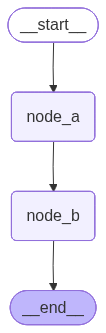

In [1]:
from typing import Annotated
from typing_extensions import TypedDict
from operator import add

from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import InMemorySaver

class State(TypedDict):
    foo: str
    bar: Annotated[list[str], add]

def node_a(state: State):
    return {"foo": "a", "bar": ["a"]}

def node_b(state: State):
    return {"foo": "b", "bar": ["b"]}


workflow = StateGraph(State)
workflow.add_node("node_a", node_a)
workflow.add_node("node_b", node_b)
workflow.add_edge(START, "node_a")
workflow.add_edge("node_a", "node_b")
workflow.add_edge("node_b", END)

"""
Checkpoints:

The state of a thread at a particular point in time is called a checkpoint. 
Checkpoint is a snapshot of the graph state saved at each superstep and is represented by StateSnapshot object.
"""

# 要取得state的內容，你必須要同時有 InMemeorySaver 和 configurable
checkpointer = InMemorySaver()
config = {"configurable": {"thread_id": "1"}}

graph = workflow.compile(checkpointer=checkpointer)
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [2]:
graph.invoke({"foo": ""}, config)

{'foo': 'b', 'bar': ['a', 'b']}

## Get state

當與已儲存的圖形狀態互動時，您必須指定一個執行緒識別碼（thread identifier）。您可以透過呼叫 graph.get_state(config) 來查看圖形的最新狀態。此方法會回傳一個 StateSnapshot 物件，該物件對應於在 config 中提供的執行緒 ID 所關聯的最新檢查點（checkpoint），或者，如果提供了檢查點 ID，則會回傳與該執行緒相關的檢查點狀態。

In [3]:
state = graph.get_state(config)
print(state)

StateSnapshot(values={'foo': 'b', 'bar': ['a', 'b']}, next=(), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0b3e73-2779-65d2-8002-85fcb600bf9f'}}, metadata={'source': 'loop', 'step': 2, 'parents': {}}, created_at='2025-10-28T10:16:41.400059+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0b3e73-2776-6e88-8001-7bdc4ca4f9ca'}}, tasks=(), interrupts=())


## Get state history

您可以透過呼叫 graph.get_state_history(config) 來取得指定執行緒的完整圖形執行歷史。此方法會回傳一個與 config 中提供的執行緒 ID 相關聯的 StateSnapshot 物件清單。值得注意的是，這些檢查點（checkpoints）會依時間順序排列，最新的檢查點／StateSnapshot 會位於清單的最前端。

In [4]:
config = {"configurable": {"thread_id": "1"}}
list(graph.get_state_history(config))

[StateSnapshot(values={'foo': 'b', 'bar': ['a', 'b']}, next=(), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0b3e73-2779-65d2-8002-85fcb600bf9f'}}, metadata={'source': 'loop', 'step': 2, 'parents': {}}, created_at='2025-10-28T10:16:41.400059+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0b3e73-2776-6e88-8001-7bdc4ca4f9ca'}}, tasks=(), interrupts=()),
 StateSnapshot(values={'foo': 'a', 'bar': ['a']}, next=('node_b',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0b3e73-2776-6e88-8001-7bdc4ca4f9ca'}}, metadata={'source': 'loop', 'step': 1, 'parents': {}}, created_at='2025-10-28T10:16:41.399053+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0b3e73-2776-6e87-8000-b612ffec4f4a'}}, tasks=(PregelTask(id='30122c1c-bce9-9bd8-c69d-e727b4e353c5', name='node_b', path=('__pregel_pull', 'node_b'), error=None, interrupts

## Get State: specific to checkpoint_id

In [5]:
state = graph.get_state({"configurable": {"thread_id": "1",
                                          "checkpoint_id": '1f0b3d75-e6a5-60d5-8001-d924b38e6b13'}})
print(state)

StateSnapshot(values={}, next=(), config={'configurable': {'thread_id': '1', 'checkpoint_id': '1f0b3d75-e6a5-60d5-8001-d924b38e6b13'}}, metadata=None, created_at=None, parent_config=None, tasks=(), interrupts=())


## Replay

也可以重播先前的圖形執行過程。若我們在呼叫圖形時同時指定 thread_id 和 checkpoint_id，系統將會重新執行對應於該 checkpoint_id 檢查點之前的所有步驟，並僅執行該檢查點之後的步驟。

- thread_id 是執行緒的識別碼。
- checkpoint_id 是指向該執行緒中某個特定檢查點的識別碼。

In [7]:
# graph.invoke(None, config={"configurable": {"thread_id": "1",
#                                             "checkpoint_id": '1f0b3d75-e6a5-60d5-8001-d924b38e6b13'}})

重要的是，LangGraph 具備辨識特定步驟是否已被執行過的能力。若某個步驟已經執行過，LangGraph 會在圖形中重播該步驟，而不會重新執行它——但這僅適用於在所提供的 checkpoint_id 之前的步驟。至於 checkpoint_id 之後的所有步驟，則都會被重新執行（即產生一個新的分支），即使這些步驟先前已經執行過。

## Resume

In [8]:
graph.invoke({"foo": "c"}, config)

{'foo': 'b', 'bar': ['a', 'b', 'a', 'b']}

## InMemoryStore

In [9]:
from langgraph.store.memory import InMemoryStore

in_memory_store = InMemoryStore()

記憶（Memories）是以一個元組（tuple）作為命名空間（namespace）來區分的，在此特定範例中為 (<user_id>, "memories")。命名空間的長度可以是任意的，並且可以代表任何內容，不一定必須與使用者相關。

In [10]:
user_id = "1"
namespace_for_memory = (user_id, "memories")

In [11]:
import uuid

memory_id = str(uuid.uuid4())

memory = {"food_preference" : "I like pizza"}

# 在特定用戶，特定主題之下，將特定內容用 memory_id 標記並且儲存
in_memory_store.put(namespace_for_memory, memory_id, memory)

### 檢索

根據用戶ID和主題來搜尋相關紀錄

In [12]:
in_memory_store.search(namespace_for_memory)

[Item(namespace=['1', 'memories'], key='d7f2fe39-10e0-437e-8eca-1ee515ae61fb', value={'food_preference': 'I like pizza'}, created_at='2025-10-28T10:17:15.486303+00:00', updated_at='2025-10-28T10:17:15.486303+00:00', score=None)]

>- value：此記憶的內容（本身為一個字典）
>- key：此命名空間中該記憶的唯一鍵值
>- namespace：由字串組成的清單，表示此記憶類型所屬的命名空間
>- created_at：此記憶的建立時間戳記
>- updated_at：此記憶的更新時間戳記

加入語意搜索

In [13]:
from langchain.embeddings import init_embeddings

In [15]:
embeded = init_embeddings("huggingface:BAAI/bge-m3")

In [27]:
len(embeded.embed_query("Hello World"))

1024

The main configuration options:

>- embed：嵌入（embedding）提供者（例如 "openai:text-embedding-3-small"），或是自訂函式的路徑（doc）。可用的 provider:model 組合取決於 LangChain 的支援。
>- dims：所選嵌入模型的維度大小（例如 OpenAI 的 text-embedding-3-small 為 1536 維）。
>- fields：要建立索引的欄位清單。可使用 ["$"] 來索引整份文件，或指定 JSON 路徑，例如 ["text", "summary", "messages[-1]"]。

In [49]:
store = InMemoryStore(
    index={
        "embed": embeded,  # Embedding provider
        "dims": 1024,                              # Embedding dimensions
        "fields": ["food_preference"]         # Fields to embed
    }
)

In [50]:
store.put(namespace_for_memory, memory_id, memory)

store.put(
    namespace_for_memory,
    str(uuid.uuid4()),
    {
        "food_preference": "I love Italian cuisine",
        "context": "Discussing dinner plans"
    },
    index=["food_preference"]  # Only embed "food_preferences" field
)

store.put(
    namespace_for_memory,
    str(uuid.uuid4()),
    {"system_info": "Last updated: 2024-01-01"},
    index=False
)

In [51]:
store.search(
    namespace_for_memory,
    query="What does the user like to eat?",
    limit=5  # Return top 3 matches
)

[Item(namespace=['1', 'memories'], key='d7f2fe39-10e0-437e-8eca-1ee515ae61fb', value={'food_preference': 'I like pizza'}, created_at='2025-10-28T10:48:53.729832+00:00', updated_at='2025-10-28T10:48:53.729832+00:00', score=0.6639824248624141),
 Item(namespace=['1', 'memories'], key='2b3639aa-4a3d-46db-afbf-6502bc9af114', value={'food_preference': 'I love Italian cuisine', 'context': 'Discussing dinner plans'}, created_at='2025-10-28T10:48:53.867637+00:00', updated_at='2025-10-28T10:48:53.867637+00:00', score=0.6459898931646416),
 Item(namespace=['1', 'memories'], key='42fecaf3-147c-41cd-9671-95acbf02928c', value={'system_info': 'Last updated: 2024-01-01'}, created_at='2025-10-28T10:48:53.867637+00:00', updated_at='2025-10-28T10:48:53.867637+00:00', score=None)]

### Search with Filter

In [47]:
store.search(namespace_for_memory, filter={"context": "Discussing dinner plans"})

[Item(namespace=['1', 'memories'], key='9ac5c177-be61-4ae7-a6f9-5d932fade177', value={'food_preference': 'I love Italian cuisine', 'context': 'Discussing dinner plans'}, created_at='2025-10-28T10:38:02.187671+00:00', updated_at='2025-10-28T10:38:02.187671+00:00', score=None)]

在Workflow中調用store

We can access the in_memory_store and the user_id in any node by passing store: BaseStore and config: RunnableConfig as node arguments. Here's how we might use semantic search in a node to find relevant memories

照著官方文件做，會報錯。

In [129]:
from langchain_core.runnables.config import RunnableConfig
from langchain_core.stores import BaseStore

class State(TypedDict):
    foo: str
    bar: Annotated[list[str], add]

def node_a(state: State, config: RunnableConfig):

    print(config["configurable"]["user_id"])

    print("*****")
    print(config['configurable']['__pregel_runtime'])
    print("*****")

    store_ = config['configurable']['__pregel_runtime'].store
    
    print(store_.search(namespace_for_memory, filter={"context": "Discussing dinner plans"}))
    
    return {"foo": "a", "bar": ["a"]}

def node_b(state: State, config: RunnableConfig):
    return {"foo": "b", "bar": ["b"]}


workflow = StateGraph(State)
workflow.add_node("node_a", node_a)
workflow.add_node("node_b", node_b)
workflow.add_edge(START, "node_a")
workflow.add_edge("node_a", "node_b")
workflow.add_edge("node_b", END)

In [130]:
checkpointer = InMemorySaver()
config = {"configurable": {"thread_id": "100",
                           "user_id": 1}}

graph = workflow.compile(checkpointer=checkpointer, store=store)

In [131]:
graph.invoke({"foo": ""},  config=config)

1
*****
Runtime(context=None, store=<langgraph.store.memory.InMemoryStore object at 0x00000268CBE93AB0>, stream_writer=<function Pregel.stream.<locals>.stream_writer at 0x00000268CC904160>, previous=None)
*****
[Item(namespace=['1', 'memories'], key='2b3639aa-4a3d-46db-afbf-6502bc9af114', value={'food_preference': 'I love Italian cuisine', 'context': 'Discussing dinner plans'}, created_at='2025-10-28T10:48:53.867637+00:00', updated_at='2025-10-28T10:48:53.867637+00:00', score=None)]


{'foo': 'b', 'bar': ['a', 'b']}

In [122]:
Q = graph.nodes['node_a']